## From Your Favorite Book to Your Favorite Podcast
Insight Fellowship・Data Demonstration<br/>
Carl Huang ( http://carlhuang.com )<br/>
Nov 9, 2020


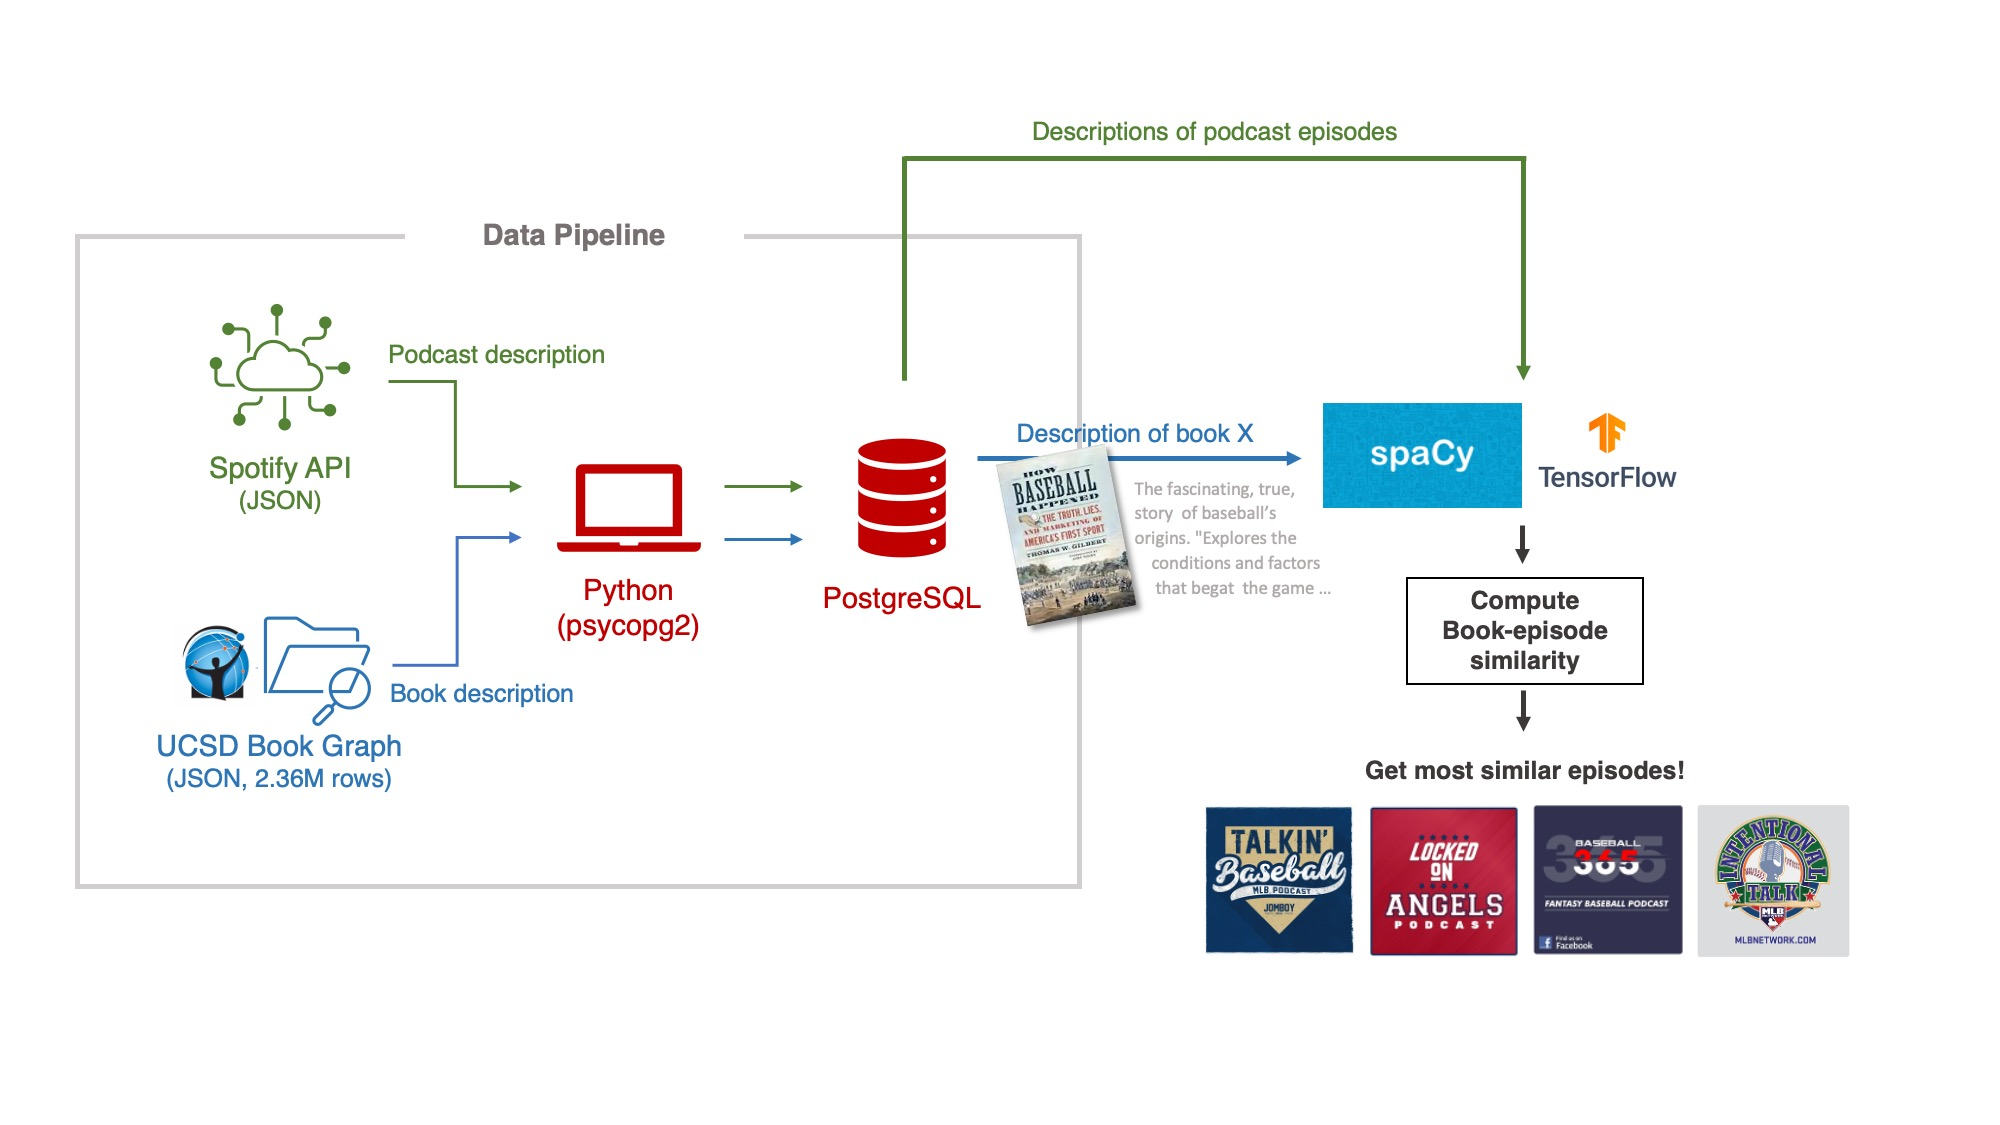

In [1]:
from IPython.display import Image
Image(filename='architecture.jpg')

In [2]:
import re
import time
import json
import configparser
import psycopg2
import random
import logging
import string
import spacy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth

import pandas as pd
import seaborn as sns
import tensorflow as tf
from langdetect import detect
from datetime import datetime

sns.set_theme(style="darkgrid")
pd.options.mode.chained_assignment = None
logging.getLogger('tensorflow').disabled = True

## 1. Data Pipeline
### 1.1 Using class to handle ETL
Since both the `Spotify API` and `UCSD Book Graph` pipelines involves (1) extracting JSON data, (2) transform data, and (3) loading data into PostgreSQL, I will build a general class to reduce redundant codes:

In [3]:
class etl_handler(object):
    "A class that loads a JSON file, transform data, and insert data into PostgreSQL tables"
    def __init__(self):
        self.config = '/Users/Carl/_data Science/_project/book to podcast/database.ini'
        self.data = None
    
    def psql_insert(self):
        return self.insert_table

    # Loading functions
    def load_json(self, json_file: str, max_line = None):
        """
        Takes a JSON file path and maximum lines to be loaded.
        Saves loaded data in self.data
        """
        data = []
        count = 0
        with open(json_file, 'r') as f:
            for line in f:
                dict_ = json.loads(line)
                data.append(dict_)
                count += 1
                if max_line:
                    if count == max_line:
                        break
            self.data = pd.DataFrame(data)

    # Data wrangling/cleaning functions
    def get_data(self, rows: int = None, random_draw: bool = False, seed: int = None):
        """
        Takes the number of rows to be displayed and whether a randome sample should be drawn.
        Returns a pandas DataFrame with specifications above.
        """
        if self.data is not None:
            if not rows:
                # If 'row' is not given, the all rows from self.data will be read.
                rows = self.data.shape[0]
            if random_draw:
                if seed:
                    return self.data.sample(n=rows, random_state=seed)
            else:
                return self.data[:rows]
        else:
            print("Error. Data not loaded. User load_json() to load data first.")
    
    def select_columns(self, cols: list):
        """Limit the columns of self.data to the columne list provided"""
        self.data = self.data[cols]
    
    def add_column(self, col_name, content):
        """Add a new column to self.data with content provided in *content* """
        self.data[col_name] = content
    
    def filter_value(self, column, value, how = None):
        """Only keeps examples that match the value conditions specified in argument"""
        if how == '==':
            self.data = self.data.loc[self.data[column] == value]

        if how == '>=':
            self.data = self.data.loc[self.data[column] >= value]

        if how == '>':
            self.data = self.data.loc[self.data[column] > value]

        if how == '<=':
            self.data = self.data.loc[self.data[column] <= value]

        if how == '<':
            self.data = self.data.loc[self.data[column] < value]
        
        self.data = self.data.reset_index(drop=True)
        return None
        
    def column_function(self, cols: list, func):
        """Apply function *func* to the specified column in self.data"""
        for col in cols:
            new_col = self.data[col].map(func)
            self.data.loc[:, col] = new_col
        return None
    
    def drop_na(self):
        self.data = self.data.dropna()
        self.data = self.data.reset_index(drop=True)
        return None
    
    # PSQL helper functions
    def psql_connect(self):
        "Given a confige file (config.ini), this function locates information PostgreSQL "
        config = configparser.ConfigParser()
        config.read(self.config)
        connection = psycopg2.connect(
            host = config['postgres']['host'],
            database = config['postgres']['database'],
            user = config['postgres']['user'],
            password = config['postgres']['password']
            )
        cursor = connection.cursor()
        return connection, cursor

### 1.1.1 Loading Book Data from UCSD Book Graph

In [4]:
class bookgraph_etl(etl_handler):
    def __init__(self):
        super().__init__()
        self.create_table = ("""CREATE TABLE IF NOT EXISTS book(
                                book_id bigint PRIMARY KEY,
                                year smallint NOT NULL,
                                rating_counts int NOT NULL,
                                title varchar(250) NOT NULL UNIQUE,
                                description varchar(500),
                                authors varchar(250),
                                language varchar(20))""")
        
        self.insert_table = ("""INSERT INTO book 
                               (book_id, year, rating_counts, title, description, authors, language)
                               VALUES (%s, %s, %s, %s, %s, %s, %s)
                               ON CONFLICT DO NOTHING""")
        
    def psql_create(self):
        return self.create_table

    def psql_insert(self):
        return self.insert_table

In [5]:
bookgraph = bookgraph_etl()
bookgraph.load_json('/Users/Carl/_data Science/_data/UCSD Bookgraph/goodreads_books.json', max_line = 10_000)

In [6]:
bookgraph.get_data(rows=5)

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,0312853122,1,[],US,,"[{'count': '3', 'name': 'to-read'}, {'count': ...",,false,4.00,,...,9,,1984,https://www.goodreads.com/book/show/5333265-w-...,https://images.gr-assets.com/books/1310220028m...,5333265,3,5400751,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film
1,0743509986,6,[],US,,"[{'count': '2634', 'name': 'to-read'}, {'count...",,false,3.23,B000FC0PBC,...,10,Abridged,2001,https://www.goodreads.com/book/show/1333909.Go...,https://s.gr-assets.com/assets/nophoto/book/11...,1333909,10,1323437,Good Harbor,Good Harbor
2,,7,[189911],US,eng,"[{'count': '58', 'name': 'to-read'}, {'count':...",B00071IKUY,false,4.03,,...,,Book Club Edition,1987,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,7327624,140,8948723,"The Unschooled Wizard (Sun Wolf and Starhawk, ...","The Unschooled Wizard (Sun Wolf and Starhawk, ..."
3,0743294297,3282,[],US,eng,"[{'count': '7615', 'name': 'to-read'}, {'count...",,false,3.49,B002ENBLOK,...,7,,2009,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,6066819,51184,6243154,Best Friends Forever,Best Friends Forever
4,0850308712,5,[],US,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,false,3.40,,...,,,,https://www.goodreads.com/book/show/287140.Run...,https://images.gr-assets.com/books/1413219371m...,287140,15,278577,Runic Astrology: Starcraft and Timekeeping in ...,Runic Astrology: Starcraft and Timekeeping in ...


### 1.1.2 Select Relevant Columns, Set Data Type
The original `bookgraph` data has 29 columns.

In [7]:
bookgraph.get_data().columns

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series'],
      dtype='object')

To provide users recommendation and relevant information, I trim down the original data into these columns below, and separate them based on "numeric" and "categorical":

In [8]:
int_cols = ['book_id', 'publication_year', 'ratings_count']
str_cols = ['title', 'description', 'authors']
bookgraph.select_columns(int_cols+str_cols)

In [9]:
def int_transform(text):
    return int(text) if text != '' else None

def str_transform(text):
    return text if len(text) != 0 else None

bookgraph.column_function(int_cols, int_transform)
bookgraph.column_function(str_cols, str_transform)

In [10]:
bookgraph.get_data()

,book_id,publication_year,ratings_count,title,description,authors
0,5333265,1984.0,3.0,W.C. Fields: A Life on Film,None,"[{'author_id': '604031', 'role': ''}]"
1,1333909,2001.0,10.0,Good Harbor,"Anita Diamant's international bestseller ""The ...","[{'author_id': '626222', 'role': ''}]"
2,7327624,1987.0,140.0,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,"[{'author_id': '10333', 'role': ''}]"
3,6066819,2009.0,51184.0,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,"[{'author_id': '9212', 'role': ''}]"
4,287140,NaN,15.0,Runic Astrology: Starcraft and Timekeeping in ...,None,"[{'author_id': '149918', 'role': ''}]"
...,...,...,...,...,...,...
9995,13036887,2011.0,3.0,My Journey: How One Woman Survived Stalin's Gulag,This is the first English translation of Olga ...,"[{'author_id': '5324004', 'role': ''}, {'autho..."
9996,34745794,NaN,4.0,Martin Arrowsmith,None,"[{'author_id': '7330', 'role': ''}]"
9997,13036881,2011.0,301.0,The Boy Behind the Red Door,This title is part of the \nMatt Wallace thou...,"[{'author_id': '4890658', 'role': ''}]"
9998,13036880,2011.0,15.0,The Portal,Harry Middleton is born in an America staggere...,"[{'author_id': '4656741', 'role': ''}]"


### 1.1.3 Dealing with NaNs and Nones

In [11]:
bookgraph.drop_na()

### 1.1.4 Increase `authors` column usability

In [12]:
# Global variable so the same author_data will not be loaded multiple times
global author_data

# The same etl_handler() can do most of the work:
author_data = etl_handler()
author_data.load_json('/Users/Carl/_data Science/_data/UCSD Bookgraph/goodreads_book_authors.json')
author_data.select_columns(['author_id','name'])
author_data = author_data.get_data().set_index('author_id')

def get_author_name(author_id: str):
    "Takes a Bookgraph author_id and returns the author's actual name"
    # [0] selects the text of an author's name without the entire pd.Series    
    return author_data.loc[author_id][0]

def get_authors(authors: list, max_len = 250):
    "Takes a list of author dictionaries, find main author, and return a list of authors in text"
    temp = list()
    for author in authors:
        # In Bookgraph, default author role is ''. Only contributors/illustrators/translators are specified
        if author.get('role') == '':
            author_id = author.get('author_id')
            author_name = get_author_name(author_id)
            temp.append(author_name)
    return ', '.join(temp)[:max_len]


In [13]:
author_data.head()

,name
author_id,
604031,Ronald J. Fields
626222,Anita Diamant
10333,Barbara Hambly
9212,Jennifer Weiner
149918,Nigel Pennick


In [14]:
bookgraph.column_function(['authors'], get_authors)
bookgraph.get_data()

,book_id,publication_year,ratings_count,title,description,authors
0,1333909,2001.0,10.0,Good Harbor,"Anita Diamant's international bestseller ""The ...",Anita Diamant
1,7327624,1987.0,140.0,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",Omnibus book club edition containing the Ladie...,Barbara Hambly
2,6066819,2009.0,51184.0,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,Jennifer Weiner
3,287141,2006.0,46.0,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",Alfred J. Church
4,6066812,2009.0,98.0,All's Fairy in Love and War (Avalon: Web of Ma...,"To Kara's astonishment, she discovers that a p...",Rachel Roberts
...,...,...,...,...,...,...
6667,15865447,2012.0,12.0,Shadows,A gripping novella by one of Southern Africa's...,Novuyo Rosa Tshuma
6668,13036887,2011.0,3.0,My Journey: How One Woman Survived Stalin's Gulag,This is the first English translation of Olga ...,Olga Adamova-Sliozberg
6669,13036881,2011.0,301.0,The Boy Behind the Red Door,This title is part of the \nMatt Wallace thou...,John Goode
6670,13036880,2011.0,15.0,The Portal,Harry Middleton is born in an America staggere...,Alan Zendell


### 1.1.5 Clean Up Title and Text Description

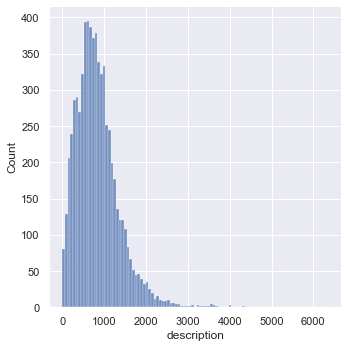

In [15]:
sns.displot(bookgraph.get_data(), x=bookgraph.get_data().description.transform(lambda x: len(x)))

#### Unusually short descriptions
A quick glance reveals that descriptions with a length shorter than 50 is rather noisy without much information that might be useful to set up a recommendation system. So for this test I decide to remove examples with descriptions like these later on.

In [16]:
print(bookgraph.get_data().loc[bookgraph.get_data().description.map(len)< 50]['description'].to_list())

['Translation of: Prestuplenie i nakazanie.', 'Playing time: 12 hours 55 mins.', '<>', 'Mit einer Einfuhrung von Frank Gohre', 'Free Download', 'Are YOU a genius? You might be surprised.', 'Darkly comic...satirical... lyrical...remarkable.', '<>\n-- Florent M.', 'The five-part finale.\nCollects issues #11-#15.', 'A novel based on the television series', 'Publishing at a later date', 'The sequel to Nascent Decay.', 'Alternate Cover Edition of ISBN # - 9781844080335', 'Historical Civil War Novel', '<>.\nIvo Andric, Estocolmo, 1961', 'Couple one of kids favorite pastimes', 'true crime/history', 'Naruto dj\nPairing: Kakashi x Iruka', 'Story of a lower middle class family', '(c) renewed 1961 by Lucia and George Joyce', 'Poesia contemporanea - Edizione fuori commercio', '16 collaborative poems in the form of "Notes."', 'Simple text and photographs present riddles.', '<>', 'First Dell Printing 1962\nCopyright 1960', '<>. (Giorgio Manganelli)', '<>[Excerto de Dickens, de Peter Ackroyd]', "lHry

#### Unusually long descriptions


In [17]:
bookgraph.get_data().description.map(len).max()

6350

In [18]:
long_text = bookgraph.get_data().loc[bookgraph.get_data().description.map(len)==6350]['description'].to_list()
long_text

["'The Cowboy Takeover' by Alysha Ellis\nSome things are worth more than money.\nMaddie is on her way to Harwood Downs Cattle Station to evict cowboy Kyson Brown from the land he loves. The property's absentee owner has leased it to an open-cut mining company.\nKyson refuses to give in without a fight, and he enlists surveyor Connor Benton to help save Harwood Downs from environmental destruction.\nWhen Maddie is stranded for a few days, Kyson and Connor show her a world of new experiences, both in bed and on the lush soil of Harwood Downs.\nMaddie's duty to her employer is clear, but how can she give up the best sexual experience of her life?\n'Tied and Taken' by BA Tortuga\nAinsley Preacher's gotten used to being more than daddy's little girl and, once she gets back to the Texas rodeo circuit, her ex, Kase, intends to find out exactly what that means.\nWhen Ainsley broke up with him a while back, bronc rider Kase just figured it was because he was too wild for that straightlaced girl

In [19]:
def standardize_description(text, max_len=500, min_len = 50):
    text = text.replace('\n',' ')
    text = text.replace("\'",'')
    # Remove web urls    
    text = re.sub('http[s]*://\S+', '', text)
    # Remove phone number
    text = re.sub('[0-9]{4}[0-9]+', '', text)
    # Remove email
    text = re.sub('\S+@\S+', '', text)
    # Remove hashtags
    text = re.sub('#\S+', '', text)
    # Remove repeating space
    text = re.sub('\s\s+', ' ', text)
    text = text.strip()
    
    # rsplit(maxsplit=1)[0] takes away only the right-most part of text separated by '. '
    text = text[:max_len].rsplit('. ', maxsplit=1)[0]
    if len(text) < min_len:
        return None
    else:
        return text
    
def standardize_title(x):
    return standardize_description(x, max_len=250, min_len = 1)

In [20]:
bookgraph.column_function(['description'], standardize_description)
bookgraph.column_function(['title'], standardize_title)
bookgraph.drop_na()

In [21]:
data = bookgraph.get_data().copy()
data

,book_id,publication_year,ratings_count,title,description,authors
0,1333909,2001.0,10.0,Good Harbor,"Anita Diamants international bestseller ""The R...",Anita Diamant
1,7327624,1987.0,140.0,"The Unschooled Wizard (Sun Wolf and Starhawk,",Omnibus book club edition containing the Ladie...,Barbara Hambly
2,6066819,2009.0,51184.0,Best Friends Forever,Addie Downs and Valerie Adler were eight when ...,Jennifer Weiner
3,287141,2006.0,46.0,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",Alfred J. Church
4,6066812,2009.0,98.0,"Alls Fairy in Love and War (Avalon: Web of Magic,","To Karas astonishment, she discovers that a po...",Rachel Roberts
...,...,...,...,...,...,...
6568,15865447,2012.0,12.0,Shadows,A gripping novella by one of Southern Africas ...,Novuyo Rosa Tshuma
6569,13036887,2011.0,3.0,My Journey: How One Woman Survived Stalins Gulag,This is the first English translation of Olga ...,Olga Adamova-Sliozberg
6570,13036881,2011.0,301.0,The Boy Behind the Red Door,This title is part of the  Matt Wallace thoug...,John Goode
6571,13036880,2011.0,15.0,The Portal,Harry Middleton is born in an America staggere...,Alan Zendell


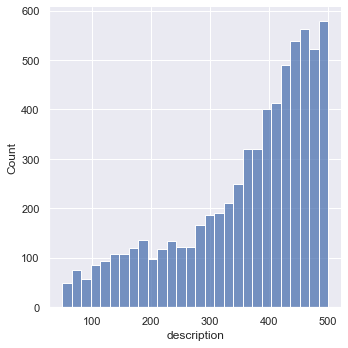

In [22]:
sns.displot(data, x = data.description.map(lambda x: len(x)))

### Language

In [23]:
now = datetime.now()
language_col = ['other' for i in range(len(bookgraph.get_data().description))]

for i in range(len(bookgraph.get_data().description)):
    try: 
        lang = detect(bookgraph.get_data().description[i])
        language_col[i] = lang
    except:
        continue

# Language detection is rather time-consuming and computationally expensive
print(datetime.now() - now)
bookgraph.add_column('language', language_col)

0:00:24.039738


<AxesSubplot:>

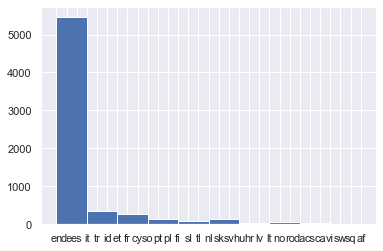

In [24]:
bookgraph.get_data().language.hist()

In [25]:
bookgraph.filter_value(column = 'language', value = 'en', how = '==')

### 1.1.6 Narrowing Years

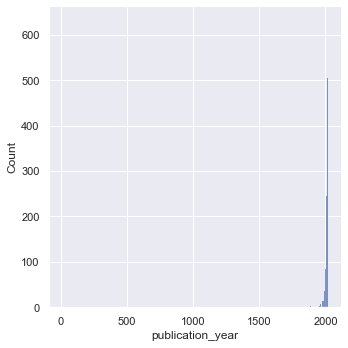

In [26]:
sns.displot(data, x='publication_year')

In [27]:
bookgraph.filter_value(column='publication_year', value=1980, how='>=')
bookgraph.filter_value(column='publication_year', value=2020, how='<=')

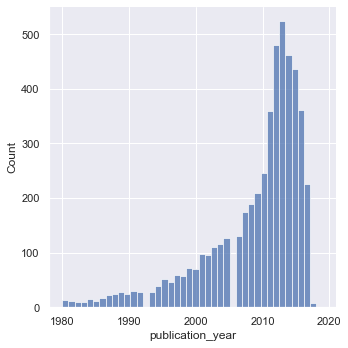

In [28]:
sns.displot(bookgraph.get_data(), x='publication_year')

### 1.1.7 Insert into PostgreSQL

In [29]:
conn, cur = bookgraph.psql_connect()

In [30]:
cur.execute(bookgraph.psql_create())
conn.commit()

In [31]:
for i, row in bookgraph.get_data().iterrows():
    cur.execute(bookgraph.psql_insert(), row)
    conn.commit()

In [32]:
conn.close()

In [33]:
%load_ext sql
%sql postgresql://carl@localhost:5432/book_podcast
%sql SELECT * FROM book LIMIT 5;   

 * postgresql://carl@localhost:5432/book_podcast
5 rows affected.


book_id,year,rating_counts,title,description,authors,language
20406298,2012,7,"Tall Tales from the Badlands, Vol","Western anthology ""Tall Tales From the Badlands"" from Black Jack Press and editor Sean Fahey returns with Volume 2, featuring some of the most exciting emerging talent in comics. ""A Nation of Laws."" Written by Sean Fahey, art by Borja ""Borch"" Pena. 1898. Arizona Territory. As the age of vigilantism is replaced by the rule of law, Sheriff Matt Ryder is about to learn that the justice system is exactly that. A ""system."" ""The Great Wall."" Written by Sean Fahey, art by Giannis Milonogiannis","Sean Fahey, Nick Nunziata, Kevin Fahey",en
7571746,2010,73,Full Circle,"Told with comedic rawness and colorful sarcasm, Elliss second novel is an epic story of love, loss, pain, and forgiveness that shines a spotlight on the painful reality of domestic abuse.",Ayana Ellis,en
13058744,2011,1,Back from the Dead: The True Sequel to Frankenstein,"What if...this morning, when you opened your newspaper, went online, turned on the TV, the headline startled your memories back to childhood fears: MARY SHELLEYS FRANKENSTEIN CREATURE FOUND... ALIVE! What if Mary Shelleys, FRANKENSTEIN, was really a true story? BACK FROM THE DEAD: the true sequel to Frankenstein is an assemblage of psychological drama, horror, romance, and science-fiction",Stuart Land,en
26826249,2015,49,"Surviving You (Shameless, #2)","""Thou shalt take the boy out of Manchester, but you cannot take Manchester out of the boy."" Lee Im a killer, a hardened criminal born into the underbelly of an unlawful world that my father crafted, and I am to be crowned the next King. I used to covet the dark; it has forever been my friend and forgives me my sins. A slither of light has dared me to hope, it has my house of cards tumbling all around me. From the moment I saw her I knew she would be my downfall",Dawn A. Keane,en
4459683,1995,1,Along Ancient Trails: The Mallet Expedition Of 1739,"Combining documents of the journey with field research and archaeological sites, Blakeslee (anthropology, Wichita State U.) delineates the route taken by a French expedition from Illinois to Santa Fe to establish trade with New Mexico",Donald J. Blakeslee,en


### 1.2.1. Loading Podcasts

In [34]:
class episode_etl(bookgraph_etl):

    def __init__(self):
        super().__init__()
        self.create_table = ("""CREATE TABLE IF NOT EXISTS episode(
                                episode_id text PRIMARY KEY NOT NULL,
                                name text NOT NULL,
                                external_url text NOT NULL, 
                                image_url text NOT NULL, 
                                language text NOT NULL,
                                release_date date NOT NULL,
                                description varchar(500) NOT NULL
                                )""")
        
        self.insert_table = ("""INSERT INTO episode 
                        (episode_id, name, release_date, description, external_url, image_url, language)
                        VALUES (%s, %s, %s, %s, %s, %s, %s)
                        ON CONFLICT (episode_id) DO NOTHING""")

            
    def spotify_connect(self):
        "Build connection with the Spotify API"
        
        config = configparser.ConfigParser()
        config.read(self.config)
        scope = "user-library-read"
        
        sp = spotipy.Spotify(auth_manager = SpotifyOAuth(scope=scope, 
                                                         client_id = config['spotify']['client_id'], 
                                                         client_secret = config['spotify']['client_secret'],
                                                         redirect_uri='http://nuthatch.carlhuang.com'))
        self.spotify_connection = sp
        return "connection established"
    
    def parse_data(self, results):
        pd_temp = list()
        cols = ['id', 'name','release_date','description','external_urls', 'images']        
        for item in results['episodes']['items']:
            d = {}
            try:
                for col in cols:
                    d[col] = item[col]
                d['external_urls'] = item['external_urls']['spotify']
                d['images'] = item['images'][-1]['url']
                # d['languages'] = item['languages'][0]
                pd_temp.append(d)

            except:
                continue
        return pd_temp
    
    def load_show(self, key='.+', target_rows = 2000, type = 'Show', random_search = False):
        "Type can either be show (podcast) or episode"
        # Spotify API limits 50 rows of query per second
        sp = self.spotify_connection
        count = 0
        offset = 0
        loaded_data = []
        
        def legal_query(key):
            temp = []
            for i in range(0, target_rows, 50):
                if offset % 100 == 0:
                    print('Retrieving rows {}/{} with key {}'.format(i, target_rows, key))
                    results = sp.search(key, market = 'US', limit = 50, offset = i, type = type)
                    temp += self.parse_data(results)
                    time.sleep(1)
            return temp
        
        if not random_search:
            loaded_data += legal_query(key)
            
        else:
            alph = list(string.ascii_lowercase) + ['.+', 'baseball']
            while len(alph) > 0:
                rdn_key = alph.pop(alph.index(random.choice(alph)))
                new_rows = legal_query(rdn_key)
                count += len(new_rows)
                loaded_data += new_rows

        self.data = pd.DataFrame(loaded_data)
        return None
    
    def drop_duplicates(self):
        self.data = self.data.drop_duplicates()
        self.data = self.data.reset_index(drop=True)
        return None


In [35]:
episode = episode_etl()
episode.spotify_connect()

'connection established'

In [36]:
episode.load_show(target_rows = 200, type="episode")

Retrieving rows 0/200 with key .+
Retrieving rows 50/200 with key .+
Retrieving rows 100/200 with key .+
Retrieving rows 150/200 with key .+


In [37]:
episode.get_data(rows = 5)

,id,name,release_date,description,external_urls,images
0,0Ts4ONY3v7HvDw1s3bPpzm,#1555 - Alex Jones & Tim Dillon,2020-10-27,"Tim Dillon is a standup comedian, actor, and h...",https://open.spotify.com/episode/0Ts4ONY3v7HvD...,https://i.scdn.co/image/8de20afe5837a23cf4ae08...
1,2EcKTkMr6zs1jXbjgnJeMM,"Dungeons and Dragons, Goldberg & NFL Trade Dea...",2020-11-04,We clean up MNF and talk about how lame the NF...,https://open.spotify.com/episode/2EcKTkMr6zs1j...,https://i.scdn.co/image/5bf530e7c8851f6547cf73...
2,3D5LxSGXNp9CbyOLWQXfRV,"Tua!!! Plus: Tampa’s No-Show, the Weirdo NFC +...",2020-11-09,The Ringer's Bill Simmons is joined by Cousin ...,https://open.spotify.com/episode/3D5LxSGXNp9Cb...,https://i.scdn.co/image/c8c73af5127dd2a316569e...
3,0FwCgmkG2Cfb36etijDIho,#1543 - Brian Muraresku & Graham Hancock,2020-09-30,Attorney and scholar Brian C. Muraresku is the...,https://open.spotify.com/episode/0FwCgmkG2Cfb3...,https://i.scdn.co/image/2ff4b14f388f4fe238ea8f...
4,4p8L4w5p95Zjt3HBT9xOns,NBA Mount GOATmore and Best 21st-Century Teams...,2020-10-09,The Ringer's Bill Simmons is joined by ESPN's ...,https://open.spotify.com/episode/4p8L4w5p95Zjt...,https://i.scdn.co/image/c8c73af5127dd2a316569e...


In [38]:
episode.drop_duplicates()

In [39]:
episode.column_function(['description'], standardize_description)

In [40]:
episode.drop_na()

In [41]:
episode.get_data(rows = 5)

,id,name,release_date,description,external_urls,images
0,0Ts4ONY3v7HvDw1s3bPpzm,#1555 - Alex Jones & Tim Dillon,2020-10-27,"Tim Dillon is a standup comedian, actor, and h...",https://open.spotify.com/episode/0Ts4ONY3v7HvD...,https://i.scdn.co/image/8de20afe5837a23cf4ae08...
1,2EcKTkMr6zs1jXbjgnJeMM,"Dungeons and Dragons, Goldberg & NFL Trade Dea...",2020-11-04,We clean up MNF and talk about how lame the NF...,https://open.spotify.com/episode/2EcKTkMr6zs1j...,https://i.scdn.co/image/5bf530e7c8851f6547cf73...
2,3D5LxSGXNp9CbyOLWQXfRV,"Tua!!! Plus: Tampa’s No-Show, the Weirdo NFC +...",2020-11-09,The Ringers Bill Simmons is joined by Cousin S...,https://open.spotify.com/episode/3D5LxSGXNp9Cb...,https://i.scdn.co/image/c8c73af5127dd2a316569e...
3,0FwCgmkG2Cfb36etijDIho,#1543 - Brian Muraresku & Graham Hancock,2020-09-30,Attorney and scholar Brian C. Muraresku is the...,https://open.spotify.com/episode/0FwCgmkG2Cfb3...,https://i.scdn.co/image/2ff4b14f388f4fe238ea8f...
4,4p8L4w5p95Zjt3HBT9xOns,NBA Mount GOATmore and Best 21st-Century Teams...,2020-10-09,The Ringers Bill Simmons is joined by ESPNs Za...,https://open.spotify.com/episode/4p8L4w5p95Zjt...,https://i.scdn.co/image/c8c73af5127dd2a316569e...


Language

In [42]:
now = datetime.now()
episode_language = ['other' for i in episode.get_data().index]

for i in episode.get_data().index:
    try: 
        lang = detect(episode.get_data().description[i])
        episode_language[i] = lang
    except:
        continue

print(datetime.now() - now)
episode.add_column('language', episode_language)

0:00:00.735068


In [43]:
episode.get_data().language.value_counts()

en    186
es      9
de      1
it      1
Name: language, dtype: int64

In [44]:
episode.filter_value(column = 'language', value = 'en', how = '==')

In [45]:
episode.get_data(rows = 5)

,id,name,release_date,description,external_urls,images,language
0,0Ts4ONY3v7HvDw1s3bPpzm,#1555 - Alex Jones & Tim Dillon,2020-10-27,"Tim Dillon is a standup comedian, actor, and h...",https://open.spotify.com/episode/0Ts4ONY3v7HvD...,https://i.scdn.co/image/8de20afe5837a23cf4ae08...,en
1,2EcKTkMr6zs1jXbjgnJeMM,"Dungeons and Dragons, Goldberg & NFL Trade Dea...",2020-11-04,We clean up MNF and talk about how lame the NF...,https://open.spotify.com/episode/2EcKTkMr6zs1j...,https://i.scdn.co/image/5bf530e7c8851f6547cf73...,en
2,3D5LxSGXNp9CbyOLWQXfRV,"Tua!!! Plus: Tampa’s No-Show, the Weirdo NFC +...",2020-11-09,The Ringers Bill Simmons is joined by Cousin S...,https://open.spotify.com/episode/3D5LxSGXNp9Cb...,https://i.scdn.co/image/c8c73af5127dd2a316569e...,en
3,0FwCgmkG2Cfb36etijDIho,#1543 - Brian Muraresku & Graham Hancock,2020-09-30,Attorney and scholar Brian C. Muraresku is the...,https://open.spotify.com/episode/0FwCgmkG2Cfb3...,https://i.scdn.co/image/2ff4b14f388f4fe238ea8f...,en
4,4p8L4w5p95Zjt3HBT9xOns,NBA Mount GOATmore and Best 21st-Century Teams...,2020-10-09,The Ringers Bill Simmons is joined by ESPNs Za...,https://open.spotify.com/episode/4p8L4w5p95Zjt...,https://i.scdn.co/image/c8c73af5127dd2a316569e...,en


PSQL

In [46]:
conn, cur = episode.psql_connect()

In [47]:
cur.execute(episode.psql_create())
conn.commit()

In [48]:
for i, row in episode.get_data().iterrows():
    cur.execute(episode.psql_insert(), row)
    conn.commit()

In [49]:
conn.close()

In [50]:
%sql SELECT * FROM episode LIMIT 1;   

 * postgresql://carl@localhost:5432/book_podcast
1 rows affected.


episode_id,name,external_url,image_url,language,release_date,description
4tu5P35SSCM2nlv34dX9U9,#1558 - Tristan Harris,https://open.spotify.com/episode/4tu5P35SSCM2nlv34dX9U9,https://i.scdn.co/image/6a234fd396b5ce3994b4d66286dfd69d0e481b34,en,2020-10-30,"Called the “closest thing Silicon Valley has to a conscience,” by The Atlantic magazine, Tristan Harris spent three years as a Google Design Ethicist developing a framework for how technology should “ethically” steer the thoughts and actions of billions of people from screens"


## 3. A Simple Recommendation Function

In [51]:
def get_book_description():
    book_des = %sql SELECT description FROM book;
    book_des = list(text[0] for text in book_des)
    return book_des

def get_book_title():
    book_title = %sql SELECT title FROM book;
    book_title = list(text[0] for text in book_des)
    return book_title

def get_episode_name():
    ep_name = %sql SELECT name FROM episode;
    ep_name = list(text[0] for text in ep_name)
    return ep_name

def get_episode_description():
    ep_des = %sql SELECT description FROM episode;
    ep_des = list(text[0] for text in ep_des)
    return ep_des

def get_episode_name():
    ep_name = %sql SELECT name FROM episode;
    ep_name = list(text[0] for text in ep_name)
    return ep_name

def get_description_from_id(book_id):
    etl = etl_handler()
    conn, cur = etl.psql_connect()
    cur.execute("SELECT description FROM book WHERE book_id = {}".format(str(book_id)))
    result = cur.fetchone()
    return result[0]

def get_title_from_id(book_id):
    etl = etl_handler()
    conn, cur = etl.psql_connect()
    cur.execute("SELECT title FROM book WHERE book_id = {}".format(str(book_id)))
    result = cur.fetchone()
    return result[0]

In [52]:
get_description_from_id(14143785)

'Americans use baseball language to describe everything. Aimed at visitors to American soil or just to American culture, this book is an illustrated guide to the game and how to use its lingo'

## Approach 1: NLP & Pre-trained Word Vector with Spacy

In [53]:
parser = spacy.load("en_core_web_lg")

def process_nlp(text, string_out = False):
    " Takes a body of text and return a lemmatized string with redundant words removed "
    doc = [i.lemma_ for i in parser(text) if not token_out_of_scope(i)] #  
    if string_out:
        return ' '.join(doc)
    else:
        return parser(' '.join(doc))

def token_out_of_scope(token):
    " Remove tokens that are punctuation or whitespace or stopwords "
    return token.is_punct or token.is_space or token.is_stop or (token.pos_ not in ['NOUN', 'ADJ', 'PROPN'])

def find_podcast(book_id):
    " Takes 1 book_id and return the most similar 5 podcast episodes from the database"
    then = datetime.now()
    
    # Take book description, do NLP tasks
    book_des = get_description_from_id(book_id)
    book_des = process_nlp(book_des)
    
    # Take episode name/description, do NLP tasks
    episodes = %sql SELECT name, description FROM episode;
    episode_name = [episodes[i][0] for i in range(len(episodes))]
    print('Calculating similarity...')
    episode_description = [episodes[i][1] for i in range(len(episodes))]
    
    similarity = list()
    # Unseen words causes empty vectors in Spacy
    for episode in episode_description:
        e = process_nlp(episode)
        if e.vector_norm:
            similarity.append(book_des.similarity(e))
        else:
            similarity.append(None)

    # Organize data into a dataframe and sort with similarity
    results = pd.DataFrame({'name': episode_name, 'des': episode_description, 'sim':similarity})
    print(datetime.now() - then)
    return results.sort_values(by='sim', ascending = False)


### Case 1: Baseball

In [54]:
%sql SELECT book_id, year, title, authors, description FROM book WHERE title ILIKE '%baseball%' LIMIT 1;

 * postgresql://carl@localhost:5432/book_podcast
1 rows affected.


book_id,year,title,authors,description
14143785,2012,Baseball as a Second Language,Harry Lewis,"Americans use baseball language to describe everything. Aimed at visitors to American soil or just to American culture, this book is an illustrated guide to the game and how to use its lingo"


In [55]:
spacy_baseball = find_podcast(book_id = 14143785)

 * postgresql://carl@localhost:5432/book_podcast
20680 rows affected.
Calculating similarity...
0:04:24.355262


In [56]:
spacy_baseball.head(5)

,name,des,sim
7340,Episode 01: Baseball’s Origins,The saying “as American as baseball and apple ...,0.863697
7087,The All-American Girls Professional Baseball L...,The 2019 World Series has Jack and Lauren in t...,0.831557
7347,"Episode 24 – The Ol’ Leather Apple (or, Baseba...","In our 24th episode, Lauren broadcasts the ori...",0.819237
7826,#171 Baseball in Context w/ Jayson Stark,"Baseball is part of America’s cultural fabric,...",0.818708
7177,061 - Baseball Culture and Expressions with Li...,In Episode my good friend Liz Johnson and I ta...,0.813417


### Case 2: Machine Learning

In [57]:
%sql SELECT book_id, title, description FROM book WHERE title ILIKE '%machine learning%' LIMIT 2;

 * postgresql://carl@localhost:5432/book_podcast
2 rows affected.


book_id,title,description
148020,Machine Learning,"This book covers the field of machine learning, which is the study of algorithms that allow computer programs to automatically improve through experience"
21887586,Thoughtful Machine Learning: A Test-Driven Approach,"Learn how to apply test-driven development (TDD) to machine-learning algorithms--and catch mistakes that could sink your analysis. In this practical guide, author Matthew Kirk takes you through the principles of TDD and machine learning, and shows you how to apply TDD to several machine-learning algorithms, including Naive Bayesian classifiers and Neural Networks. Machine-learning algorithms often have tests baked in, but they cant account for human errors in coding"


In [58]:
spacy_ml = find_podcast(book_id = 148020)
spacy_ml.head(5)

 * postgresql://carl@localhost:5432/book_podcast
20680 rows affected.
Calculating similarity...
0:04:18.421849


,name,des,sim
12032,Computer security or CyberSecurity in relation...,A different perspective or analogy relating co...,0.816632
18751,#649: Thinking for Yourself in an Age of Outso...,"In an age where endless streams of data, optio...",0.788320
18655,#656: The Hidden Pleasures of Learning for Its...,"When we typically think about learning, we ten...",0.786283
20219,The Psychology of Success | Tony Robbins and X...,"When a business is struggling, most business o...",0.775074
5992,Question Your Questions: How to Spark Creativi...,“Sparking communication starts with asking why...,0.774789


## Approach 2: TF-IDF with Tensorflow

In [59]:
vec_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = 10_000, 
    standardize = 'lower_and_strip_punctuation',
    split = 'whitespace', 
    output_mode= "tf-idf")

In [62]:
book_title = get_book_title()
book_des = get_book_description()
episode_name = get_episode_name()
episode_des = get_episode_description()

vec_layer.adapt(book_title + book_des + episode_name + episode_des)

 * postgresql://carl@localhost:5432/book_podcast
161600 rows affected.
 * postgresql://carl@localhost:5432/book_podcast
161600 rows affected.
 * postgresql://carl@localhost:5432/book_podcast
20680 rows affected.
 * postgresql://carl@localhost:5432/book_podcast
20680 rows affected.


In [63]:
def find_podcast_tf_idf(book_id):
    
    book_title = get_title_from_id(book_id)
    book_des = get_description_from_id(book_id)

    episode_body = [episode_name[i] + ' ' + episode_des[i] for i in range(len(episode_name))]    
        
    similarity = tf.keras.losses.cosine_similarity(
        vec_layer([book_title + ' ' + book_des]), vec_layer(episode_body)
    )
    
    results = pd.DataFrame({
        'episode': get_episode_name(),
        'description': episode_des,
        'sim' : similarity
    })
    
    return results.sort_values(by='sim', ascending = True)

### Case 1: Baseball

In [65]:
tf_baseball = find_podcast_tf_idf(book_id = 14143785)

 * postgresql://carl@localhost:5432/book_podcast
20680 rows affected.


In [66]:
tf_baseball.head(5)

,episode,description,sim
6494,Baseball,Batter up! Its time to learn a little about Am...,-0.306156
7340,Episode 01: Baseball’s Origins,The saying “as American as baseball and apple ...,-0.295972
7724,Ronnie Morales- Dir. of Baseball at West Ralei...,Baseball and the growth of the game is routed ...,-0.293193
6744,72. Baseball’s Greatest Legends | The Secret L...,"We were joined by Craig Calcaterra, baseball w...",-0.291499
7885,002 - BASEBALL,"In this episode we take a look at Baseball, a ...",-0.289133


### Case 2: Machine Learning

In [67]:
tf_ml = find_podcast_tf_idf(book_id = 148020)

 * postgresql://carl@localhost:5432/book_podcast
20680 rows affected.


In [68]:
tf_ml.head(10)

,episode,description,sim
20622,Episode 99: My Little Machine,A truly democratic machine and the man who did...,-0.354619
10566,420: Renee DiResta | Dismantling the Disinform...,Renee DiResta is the technical research manage...,-0.247338
19798,8 – The Time Machine,Zzz. . . Snooze sweetly while Kristen reads th...,-0.238633
5167,NFL Week 3 Preview. Torrey Smith on Cam Newton...,(1:47) - Thursday Night Football Recap. (13:45...,-0.237947
18604,r/Prorevenge Scam Me? I'll Trick You Out of $1...,r/Prorevenge What happens when a company tries...,-0.234297
8857,Local Hour: A Barren Vending Machine,The Le Batard crew tries not to poopoo on the ...,-0.231661
2595,"Fantasy Time Machine + Credit, Blame, and Brow...",Step into the Fantasy Time Machine! The Fantas...,-0.219755
9140,1414: The Truth About the Leg Extension Machin...,"In this episode of Quah (Q & A), Sal, Adam & J...",-0.203446
3542,"From Air Travel to Hospital Treatment, We're ...","Francis Collins, director of the National Inst...",-0.195707
19766,Time Traveler,"Just a few weeks ago, writer and performer Jac...",-0.194454


## 4. Future Steps

* Online deployment at http://nuthatch.carlhuang.com/

* Improve data quality

* Automate data pipeline 